# Unsupervised Anomaly Detection using Vector Embeddings from <U>doc2vec model</U>
This is a continuation of the prior research. In this notebook, we are leveraging the <u>Isolation Forest</u> algorithm to perform unsupervised training of an anomaly detection model, using text <u>vector embeddings</u> as the input. in this working example, we will build a doc2vec model using known benign logs and use that to calculate vector embeddings for the logs we wish to analyze for anomalies.

In [11]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas 
#! pip install matplotlib
#! pip install scikit-learn
#! pip install gensim
#! pip install nltk
#import nltk
#nltk.download('punkt_tab')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec

In [2]:
# Build a vector embedding model with doc2vec using the benign sample logs
df = pd.read_csv('proxy_logs_good.csv')
documents = df['Log Entry'].values

# Generate the tagged documents
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(documents)]

# vector_size: size of the document vectors
# window: context window size (how many words before and after to look)
# min_count: minimum word frequency
# workers: number of CPU cores to use
# dm: 1 for Distributed Memory (DM), 0 for Distributed Bag of Words (DBOW)
embedder_model = Doc2Vec(vector_size=32, window=5, min_count=2, workers=4, dm=1)

# Build vocabulary
embedder_model.build_vocab(tagged_data)

# Train the model
embedder_model.train(tagged_data, total_examples=embedder_model.corpus_count, epochs=embedder_model.epochs)

# Save the model
embedder_model.save("doc2vec-embedding-model_benign-proxy-logs-v1.model")


In [3]:
# Do a test inference to see if the vector embedding looks like something we'd expect...so far, so good
new_doc = word_tokenize('GET http://www.example.com/ HTTP/1.1"" 200 140321 ""http://www.example.com/"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15')
sample_vector = embedder_model.infer_vector(new_doc)
sample_vector


array([-0.05277269, -0.02061502,  0.05451095, -0.01595709, -0.01096546,
        0.00971476,  0.00045772, -0.00113055, -0.00455683,  0.00758379,
        0.0188623 , -0.02847895, -0.00828664, -0.00433221, -0.00119784,
       -0.00911118, -0.02476585, -0.03072584,  0.02192181, -0.01981285,
       -0.01206895,  0.00261984,  0.0743035 ,  0.05318459,  0.00669283,
        0.00772004, -0.0373749 ,  0.00103769, -0.06598211, -0.00953463,
       -0.02666268, -0.01690255], dtype=float32)

In [4]:
# We'll use the fabricated mixed proxy logs with known 950 benign log entries and 50 malicious log entries 
# Our goal is to see if we can get them accurately classified into that 950 benign + 50 malicious
# Read the log data into a dataframe, and drop the columns we don't need for this exercise, and 
# extract the return code to use in validating the eventual output
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df['return_code'] = df['Log Entry'].str.split().str[3]

df.sample(3)

,ID,Log Entry,return_code
500,501,GET http://update.software.com/version.xml HTT...,200
481,482,"GET http://www.example.com/style.css HTTP/1.1""...",200
781,782,"GET http://update.software.com/check HTTP/1.1""...",200


In [5]:
# Let's confirm that we have 950 benign (rc = 200) and 50 malicious (rc != 200)
df['return_code'].value_counts()

return_code
200    950
403     18
500     11
404     11
400     10
Name: count, dtype: int64

In [6]:
# We'll use the doc2vec model that we trained above to calculate vector embeddings for these logs

# Use a lambda function to encode the text in each row and apply it to a new column
df['embedding'] = df['Log Entry'].apply(lambda text: embedder_model.infer_vector(word_tokenize(text.lower())))

df.sample(3)

,ID,Log Entry,return_code,embedding
648,649,"GET http://intranet.company.com/home HTTP/1.1""...",200,"[-0.024412155, -0.011967024, -0.0015383441, -0..."
129,130,"GET http://cloudstorage.com/files HTTP/1.1"" 20...",200,"[0.022252766, 0.021762382, 0.009770124, -0.045..."
113,114,GET http://update.software.com/version.xml HTT...,200,"[-0.011288161, -0.04156033, 0.047528263, 0.012..."


In [7]:
# Define a model object with the Isolation Forest algorithm
model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding'].values)

# Fit the data to the model
model.fit(X)

# Display parameter values that were used
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [8]:
# Add a column to the DF for scores from the model's decision_function
df['raw_score'] = model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score'] = model.predict(X)


In [9]:
# Display the data with the columns added
df.sample(3)

,ID,Log Entry,return_code,embedding,raw_score,anomaly_score
640,641,GET http://cloudstorage.com/authenticate HTTP/...,200,"[0.0013630829, 0.027929612, 0.01466123, 0.0333...",0.094217,1
995,996,"GET http://www.example.com/admin HTTP/1.1"" 400...",400,"[-0.031203456, -0.033730242, 0.065842725, 0.02...",0.118345,1
487,488,GET http://update.software.com/version.xml HTT...,200,"[-0.032671098, -0.037267763, 0.052770045, 0.02...",0.109804,1


In [10]:
# Display just the anomalies
df[df['anomaly_score']==-1].sample(3)

,ID,Log Entry,return_code,embedding,raw_score,anomaly_score
388,389,GET http://cloudstorage.com/authenticate HTTP/...,200,"[-0.08166126, -0.01737984, 0.09441773, 0.04125...",-0.055055,-1
437,438,"GET http://update.software.com/check HTTP/1.1""...",200,"[-0.005105644, 0.055145502, -0.05518502, 0.025...",-0.027272,-1
46,47,"GET http://cloudstorage.com/login HTTP/1.1"" 20...",200,"[-0.0013712061, -0.08142814, 0.08335051, 0.066...",-0.000382,-1


In [11]:
# The outliers have anomaly_score = -1 
# This output is much better than the 711/289 split we got from prior clustering exercises.
# NOTE:  Setting max_samples very high helps...the output below is very close to the known 950/50

# We could perhaps dig into the data to validate, then adjust contamination parameter to get better 
# on-going accuracy from this unsupervised algorithm. It would be worth trying with real data.
df['anomaly_score'].value_counts()

anomaly_score
 1    937
-1     63
Name: count, dtype: int64

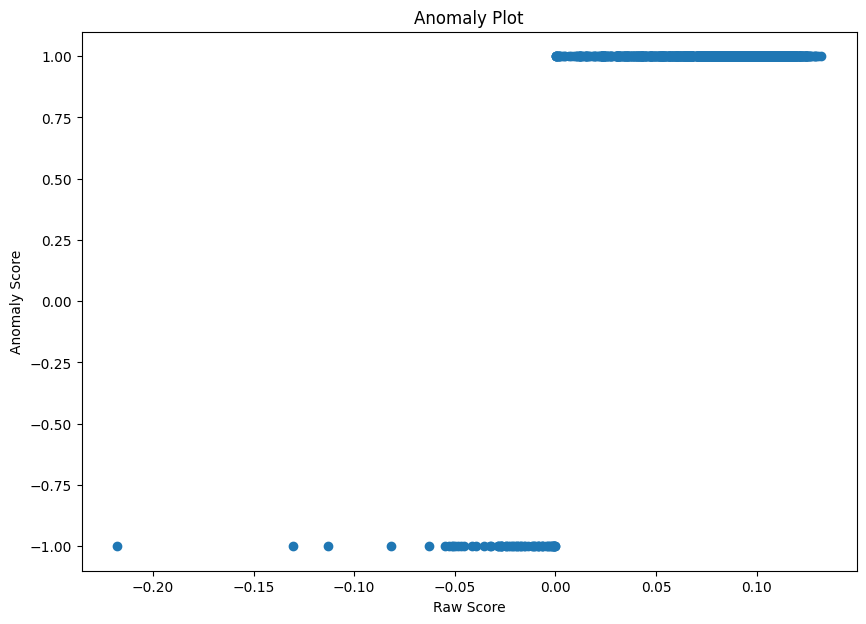

In [12]:
# If we just do a scatter plot of the anomaly_score results, it's very clear...but doesn't really tell us much.
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df.raw_score, df.anomaly_score)
plt.title('Anomaly Plot')
plt.xlabel('Raw Score')
plt.ylabel('Anomaly Score')
plt.show()

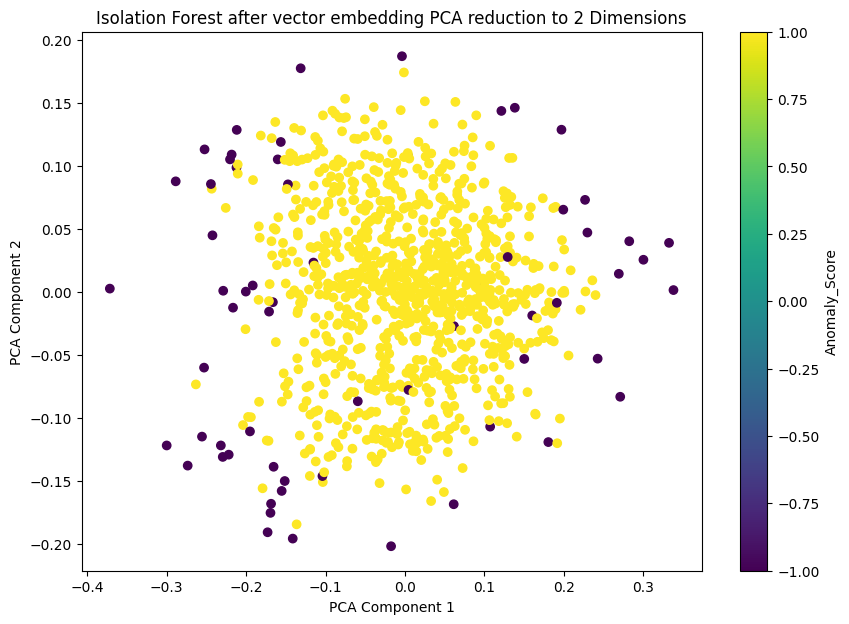

In [13]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings = df['embedding'].tolist()
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['anomaly_score'], cmap='viridis', marker='o')
plt.title('Isolation Forest after vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()

In [14]:
# Let's examine whether the flagged anomalies include the 50 known malicious log entries
print("GOOD: Count of entries flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))
print("FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("GOOD: Count of entries not flagged anomaly and return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))

GOOD: Count of entries flagged anomaly and return_code not 200: 6
FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: 57
FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: 44
GOOD: Count of entries not flagged anomaly and return_code is 200: 893


In [15]:
# This approached returned 43 "false negatives"...model is not very accurate.
pd.set_option('max_colwidth', None) # show full width of cols
df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score', 'Log Entry']]


,return_code,anomaly_score,Log Entry
950,500,1,"GET http://www.example.com/login.php?user=admin'-- HTTP/1.1"" 500 418666 ""http://www.example.com/login.php?user=admin'--"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
951,403,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 403 183373 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
953,404,1,"GET http://www.example.com/search?q=<script>alert('xss')</script> HTTP/1.1"" 404 995505 ""http://www.example.com/search?q=<script>alert('xss')</script>"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
954,400,1,"GET http://www.example.com/search?q=<script>alert('xss')</script> HTTP/1.1"" 400 463333 ""http://www.example.com/search?q=<script>alert('xss')</script>"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
955,404,1,"GET http://www.example.com/login.php?user=admin'-- HTTP/1.1"" 404 55432 ""http://www.example.com/login.php?user=admin'--"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
956,500,1,"GET http://www.example.com/../../etc/passwd HTTP/1.1"" 500 654215 ""http://www.example.com/../../etc/passwd"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
957,403,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 403 66239 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
958,400,1,"GET http://www.example.com/login.php?user=admin'-- HTTP/1.1"" 400 627458 ""http://www.example.com/login.php?user=admin'--"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
960,403,1,"GET http://www.example.com/admin HTTP/1.1"" 403 98619 ""http://www.example.com/admin"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
961,404,1,"GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1"" 404 395488 ""http://www.example.com/index.php?page=../../../../../../etc/passwd"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"


In [16]:
# Let's examine the "false positives"...rows flagged as anomaly but have return_code 200
pd.set_option('max_colwidth', None) # show full width of showing cols
df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score', 'Log Entry']]


,return_code,anomaly_score,Log Entry
9,200,-1,"GET http://cloudstorage.com/authenticate HTTP/1.1"" 200 992808 ""http://cloudstorage.com/authenticate"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
16,200,-1,"GET http://intranet.company.com/home HTTP/1.1"" 200 69938 ""http://intranet.company.com/home"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
46,200,-1,"GET http://cloudstorage.com/login HTTP/1.1"" 200 257748 ""http://cloudstorage.com/login"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
47,200,-1,"GET http://www.example.com/ HTTP/1.1"" 200 123633 ""http://www.example.com/"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
51,200,-1,"GET http://update.software.com/version.xml HTTP/1.1"" 200 456635 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
64,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 189877 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
86,200,-1,"GET http://update.software.com/check HTTP/1.1"" 200 892468 ""http://update.software.com/check"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
88,200,-1,"GET http://intranet.company.com/home HTTP/1.1"" 200 695946 ""http://intranet.company.com/home"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
115,200,-1,"GET http://cloudstorage.com/authenticate HTTP/1.1"" 200 1003853 ""http://cloudstorage.com/authenticate"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
132,200,-1,"GET http://intranet.company.com/docs/document.pdf HTTP/1.1"" 200 49135 ""http://intranet.company.com/docs/document.pdf"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"


We know from our previous similar exercise that Isolation Forest did a very good job of finding anomalies in this sample data if we give it accurate vector embeddings as the input.  Unlike using a basic vector embedding LLM, our home-grown doc2vec model did not do particularly well in producing vector embeddings that capture the "semantic understanding" of what a malicious vs benign log appears to be. We can examine if adjusting vector dimensions or other parameters has a positive impact on it's accuracy.